# Importation des librairies

In [4]:
import numpy as np
import pandas as pd
from math import log
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.metrics import accuracy_score
import six
from sklearn.model_selection import train_test_split

In [5]:
#import warnings
#warnings.filterwarnings("ignore")

# Création du jeu de données

In [6]:
data = {'age' : ['<=30','<=30','31-40','>40','>40','>40','31-40','<=30','<=30','>40','<=30','31-40','31-40','>40'],
        'revenu' : ['eleve','eleve','eleve','moyen','faible','faible','faible','moyen','faible','moyen','moyen','moyen','eleve','moyen'],
        'etudiant': ['non','non','non','non','oui','oui','oui','non','oui','oui','oui','non','oui','non'],
        'credit' : ['bon','excellent','bon','bon','bon','excellent','excellent','bon','bon','bon','excellent','excellent','bon','excellent'],
        'achat' : [0,0,1,1,1,0,1,0,1,1,1,1,1,0]}

In [7]:
df = pd.DataFrame(data)
display(df)

,age,revenu,etudiant,credit,achat
0,<=30,eleve,non,bon,0
1,<=30,eleve,non,excellent,0
2,31-40,eleve,non,bon,1
3,>40,moyen,non,bon,1
4,>40,faible,oui,bon,1
5,>40,faible,oui,excellent,0
6,31-40,faible,oui,excellent,1
7,<=30,moyen,non,bon,0
8,<=30,faible,oui,bon,1
9,>40,moyen,oui,bon,1


In [8]:
# On isole la variable dépendantes et les variables indépendantes
y = df.achat
X = df.drop('achat', axis=1)

In [9]:
display(y)

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: achat, dtype: int64

In [10]:
display(X)

,age,revenu,etudiant,credit
0,<=30,eleve,non,bon
1,<=30,eleve,non,excellent
2,31-40,eleve,non,bon
3,>40,moyen,non,bon
4,>40,faible,oui,bon
5,>40,faible,oui,excellent
6,31-40,faible,oui,excellent
7,<=30,moyen,non,bon
8,<=30,faible,oui,bon
9,>40,moyen,oui,bon


In [11]:
# On va utiliser l'algorithme Cart donc on doit avoir que des embranchements binaires 
# Certaines variables ont plus que 2 modalités (niveau de granularité plus fin)
X = pd.get_dummies(data=X, drop_first=True)

In [12]:
display(X)

,age_<=30,age_>40,revenu_faible,revenu_moyen,etudiant_oui,credit_excellent
0,1,0,0,0,0,0
1,1,0,0,0,0,1
2,0,0,0,0,0,0
3,0,1,0,1,0,0
4,0,1,1,0,1,0
5,0,1,1,0,1,1
6,0,0,1,0,1,1
7,1,0,0,1,0,0
8,1,0,1,0,1,0
9,0,1,0,1,1,0


In [13]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

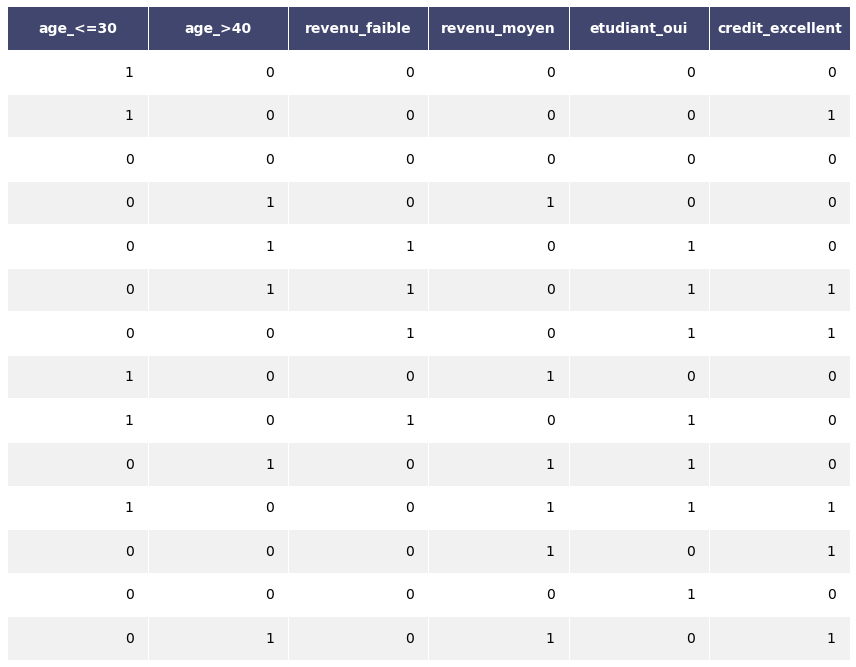

In [14]:
render_mpl_table(X, header_columns=0, col_width=2)
plt.tight_layout()
plt.show()
#plt.savefig('keras_results.svg')

# Algorithme arbre de décision

## Fonction meilleur_split

In [1]:
def meilleur_split(X, y, indice='gini'):
    #liste_gini_all_features = [] # Pour la visualisation graphique ci-après
    liste_finale = [] # Permet de stocker les informations du meilleur feature (indice d'impureté pondéré le plus faible)
    z = 0 # On instancie un compteur 
    proportion_noeud_pere = y.loc[X.index].sum() / y.loc[X.index].shape[0] # On peut faire loc sur des index car ce sont les labels des rows
                                                                           # calcul somme des true pour tout le df
    for i in X.columns: # On itère sur chaque feature dans notre dataframe
        for j in X[i].unique(): # On itère sur chaque modalité unique comprise dans chaque feature 
            true = X[X[i] > j].index # On pose les questions pour trouver les chemins true et false
            false = X[X[i] <= j].index # On utilise les index pour quand on aura un subset du dataframe (Surtout pour les variables continues)
            
            #true_df = X.loc[true].index
            #false_df = X[false].index
            
            if len(y[true].index) == 0 or len(y[false].index) == 0: # Pour se prémunir d'un dénominateur nulle quand il n'y a aucune observation qui respecte la condition
                continue # Permet à la boucle for de sauter à l'itération suivante 
            
            proportion_true = y.loc[true].sum() / y.loc[true].shape[0] # Proportion de 1 pour true
            proportion_false = y.loc[false].sum() / y.loc[false].shape[0] # Proportion de 1 pour false
        
            if indice == 'gini': # Version si l'indice d'impureté est gini
                
                gini_feature_true = 1 - (y[true].sum()/len(y[true]))**2 - (1 - (y[true].sum()/len(y[true])))**2 # calcul de gini pour true
                gini_feature_false = 1 - (y[false].sum()/len(y[false]))**2 - (1 - (y[false].sum()/len(y[false])))**2 # calcul de gini pour false
        
                impurete_feature = len(y[true])/len(y[true] + y[false])*gini_feature_true + len(y[false])/len(y[true] + y[false])*gini_feature_false # calcul de gini pondéré
        
                impurete_noeud_pere = 1 - (proportion_noeud_pere**2) - (1 - proportion_noeud_pere)**2 # calcul indice de gini du pere 
            
                gain_info = impurete_noeud_pere - impurete_feature # calcul du gain informationnel
            
            
            if indice == 'entropie': # version si l'indice d'impureté est entropie
                if proportion_true == 0 or proportion_true == 1:
                    entropie_feature_true = 0
                    
                elif proportion_true != 0 or proportion_true != 1:
                    entropie_feature_true = -(proportion_true*(log(proportion_true)/log(2)) + (1-proportion_true)*(log(1-proportion_true)/log(2)))
                
                if proportion_false == 0 or proportion_false == 1:
                    entropie_feature_false = 0
                    
                elif proportion_false != 0 or proportion_false != 1:
                    entropie_feature_false = -(proportion_false*(log(proportion_false)/log(2)) + (1-proportion_false)*(log(1-proportion_false)/log(2)))
                
                impurete_feature = len(y[true])/len(y[true] + y[false])*entropie_feature_true + len(y[false])/len(y[true] + y[false])*entropie_feature_false
                
                impurete_noeud_pere = -(proportion_noeud_pere*(log(proportion_noeud_pere)/log(2)) + (1-proportion_noeud_pere)*(log(1-proportion_noeud_pere)/log(2)))

                gain_info = impurete_noeud_pere - impurete_feature
                
            liste_temp = [i, j, gain_info, impurete_feature, proportion_true, proportion_false, true, false] # On stock les informations de manière temporaire
        
            #liste_gini_all_features.append(liste_temp) # Pour la visualisation graphique ci-après
            
            if z == 0: 
                liste_finale = liste_temp # Contient les informations du feature évalué lors de la 1ère itération
                z += 1 # On incrémente la valeur de z de 1
            
            elif z > 0:
                if impurete_feature < liste_finale[3]: # Si l'indice d'impureté pondéré < celui dans liste_finale
                    liste_finale = liste_temp # On met à jour les informations de liste_finale 
                
            true_path = X.loc[liste_finale[6]].drop(liste_finale[0], axis=1) # Mise à jour du dataframe avec le chemin gauche
            false_path = X.loc[liste_finale[7]].drop(liste_finale[0], axis=1) # Mise à jour du dataframe avec le chemin droit
            
    return true_path, false_path, liste_finale # On retourne le chemin vrai, le chemin faux et les informations de liste_finale
    #return liste_gini_all_features

### Visualisation graphique

In [111]:
# Visualiser les indices de gini pour tous les features
df_gini_all_features = pd.DataFrame(data=meilleur_split(X, y))
display(df_gini_all_features)

,0,1,2,3,4,5,6,7
0,age_<=30,0,0.065533,0.393651,0.400000,0.777778,"Int64Index([0, 1, 7, 8, 10], dtype='int64')","Int64Index([2, 3, 4, 5, 6, 9, 11, 12, 13], dty..."
1,age_>40,0,0.002041,0.457143,0.600000,0.666667,"Int64Index([3, 4, 5, 9, 13], dtype='int64')","Int64Index([0, 1, 2, 6, 7, 8, 10, 11, 12], dty..."
2,revenu_faible,0,0.009184,0.450000,0.750000,0.600000,"Int64Index([4, 5, 6, 8], dtype='int64')","Int64Index([0, 1, 2, 3, 7, 9, 10, 11, 12, 13],..."
3,revenu_moyen,0,0.000850,0.458333,0.666667,0.625000,"Int64Index([3, 7, 9, 10, 11, 13], dtype='int64')","Int64Index([0, 1, 2, 4, 5, 6, 8, 12], dtype='i..."
4,etudiant_oui,0,0.091837,0.367347,0.857143,0.428571,"Int64Index([4, 5, 6, 8, 9, 10, 12], dtype='int...","Int64Index([0, 1, 2, 3, 7, 11, 13], dtype='int..."
5,credit_excellent,0,0.030612,0.428571,0.500000,0.750000,"Int64Index([1, 5, 6, 10, 11, 13], dtype='int64')","Int64Index([0, 2, 3, 4, 7, 8, 9, 12], dtype='i..."


In [112]:
# On garde juste les features et les indices de gini pondérés des features
df_gini_all_features = df_gini_all_features.loc[:, [0,3]]
df_gini_all_features.columns = ['Features', 'Gini index']

In [113]:
df_gini_all_features.sort_values(by='Gini index', inplace=True)

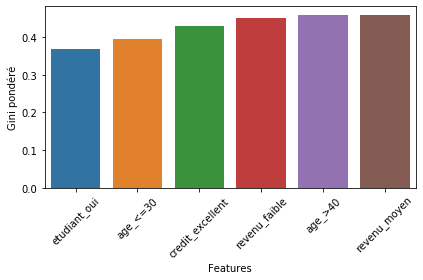

In [120]:
sns.barplot(x='Features', y='Gini index', data=df_gini_all_features)
plt.xticks(rotation=45)
plt.ylabel('Gini pondéré')
plt.tight_layout()
plt.show()
#plt.savefig('indice_gini.svg')

## Fonction construction_arbre

In [2]:
def construction_arbre(X, y, max_depth=3, gain_info_min = 0.01, indice='gini'): # Hyper paramètres pour limiter la croissance de l'arbre
    nb_elements = 2**((max_depth+1)) # Nombre d'éléments dans la liste indexé à 0
    binary_heap = [0] * nb_elements # Creation d'une liste vierge    
    
    for i in range(1, 2**max_depth): # Pour ne pas construire les enfants du dernier etage vs nb elements auparavant
        if i == 1:
            binary_heap[1] = X.index
            split1 = meilleur_split(X, y, indice)
            binary_heap[2] = list(split1[2][s] for s in [0, 1, 2, 3, 4, 6])
            binary_heap[3] = list(split1[2][s] for s in [0, 1, 2, 3, 5, 7])
            
        elif i != 1:
            if binary_heap[i] != 0: # Pour prévenir les cas ou il n'y a pas d'enfants
                gain_info = binary_heap[i][2]
                proportion_true_false = binary_heap[i][-2]
            
                if (gain_info > gain_info_min) & (proportion_true_false != 0) & (proportion_true_false != 1):
                
                    index = binary_heap[i][-1]
                    df = X.loc[index]
                    split = meilleur_split(df, y, indice)
            
                    binary_heap[2*i] = list(split[2][s] for s in [0, 1, 2, 3, 4, 6])
                    binary_heap[(2*i)+1] = list(split[2][s] for s in [0, 1, 2, 3, 5, 7])
                      
    return binary_heap         
                
# Prendre un compte les enfants dans le for loop car on appelle binary_heap[i]

In [15]:
binary_heap = construction_arbre(X, y, max_depth=3, gain_info_min = 0.01, indice='gini')

In [16]:
binary_heap

[0,
 RangeIndex(start=0, stop=14, step=1),
 ['etudiant_oui',
  0,
  0.09183673469387743,
  0.3673469387755103,
  0.8571428571428571,
  Int64Index([4, 5, 6, 8, 9, 10, 12], dtype='int64')],
 ['etudiant_oui',
  0,
  0.09183673469387743,
  0.3673469387755103,
  0.42857142857142855,
  Int64Index([0, 1, 2, 3, 7, 11, 13], dtype='int64')],
 ['age_>40',
  0,
  0.054421768707483054,
  0.19047619047619047,
  0.6666666666666666,
  Int64Index([4, 5, 9], dtype='int64')],
 ['age_>40',
  0,
  0.054421768707483054,
  0.19047619047619047,
  1.0,
  Int64Index([6, 8, 10, 12], dtype='int64')],
 ['age_<=30',
  0,
  0.27551020408163274,
  0.21428571428571427,
  0.0,
  Int64Index([0, 1, 7], dtype='int64')],
 ['age_<=30',
  0,
  0.27551020408163274,
  0.21428571428571427,
  0.75,
  Int64Index([2, 3, 11, 13], dtype='int64')],
 ['credit_excellent',
  0,
  0.4444444444444444,
  0.0,
  0.0,
  Int64Index([5], dtype='int64')],
 ['credit_excellent',
  0,
  0.4444444444444444,
  0.0,
  1.0,
  Int64Index([4, 9], dtype=

## Fonction prediction

In [41]:
def prediction(df, binary_heap):
    
    i = 2 # C'est le début du heap car i=1 contient tout le dataframe
    proportion = 0 # Le mettre en dehors car dans la boucle while, c'est une variable locale
    
    while i < len(binary_heap): # Ne pas dépasser le nombre de feuilles terminales 
        if binary_heap[i] != 0: # Éviter les cas où il n'y a pas d'enfants
            if df[binary_heap[i][0]] > binary_heap[i][1]: # On repose la question (chemin vrai)
                proportion = binary_heap[i][-2] # Contient l'information de la proportion de 1 dans true
                i = 2*i # Enfant de true se trouve à gauche
            elif df[binary_heap[i][0]] <= binary_heap[i][1]: # On repose la question (chemin faux)
                proportion = binary_heap[i+1][-2] # Contient l'information de la proportion de 1 dans false
                i = 2*(i+1) # Enfant de false se trouve à droite
                
        elif binary_heap[i] == 0: # Pour empêcher de rerentrer dans la boucle while car on ne met pas à jour le i
            break # La boucle s'arrête dès qu'on tombe sur une feuille terminale
    
    return proportion # On retourne la proportion de 1 dans true ou false

# Test de rapidité

## Dataframe généré aléatoirement 
Pour tester la rapidité de prédiction de notre algorithme sur un gros jeu de données

In [63]:
xpred = {'age_<=30':np.random.randint(2, size=1000000), 'age_>40':np.random.randint(2, size=1000000), 'revenu_faible':np.random.randint(2, size=1000000), 'revenu_moyen':np.random.randint(2, size=1000000), 'etudiant_oui':np.random.randint(2, size=1000000), 'credit_excellent':np.random.randint(2, size=1000000), 'achat':np.random.randint(2, size=1000000)}
xpred_df = pd.DataFrame(xpred)
display(xpred_df.head())

,age_<=30,age_>40,revenu_faible,revenu_moyen,etudiant_oui,credit_excellent,achat
0,0,1,1,0,0,1,0
1,0,0,0,0,1,1,1
2,0,1,0,1,1,1,1
3,0,1,0,1,0,1,1
4,0,1,1,0,1,1,1


In [66]:
xpred_df.shape

(1000000, 7)

In [52]:
X = xpred_df.drop('achat', axis=1)
y = xpred_df.achat

In [53]:
binary_heap = construction_arbre(X, y, max_depth=3, gain_info_min = 0.01, indice='gini')

`Prédiction avec une for loop`

In [54]:
for i in xpred_df.index:
    xpred_df['prediction'] = prediction(xpred_df.loc[i], binary_heap)

`Prédiction avec une list comprehension`

In [50]:
# Code avec une list comprehension (compilé en c++)
xpred_df['prediction'] = [prediction(xpred_df.loc[i], binary_heap) for i in xpred_df.index]

`Prédiction avec apply`

In [40]:
# Code avec apply (méthode de pandas)
xpred_df['prediction'] = xpred_df.apply(lambda df: prediction(df, binary_heap), axis=1)

`Dataframe résumant les méthodes (complexité différentes) et le temps d'exécution`

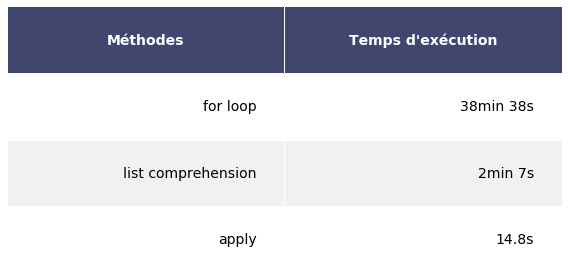

In [57]:
dict_results = {'Méthodes':['for loop', 'list comprehension', 'apply'], 'Temps d\'exécution':['38min 38s', '2min 7s', '14.8s']}

df_results = pd.DataFrame(dict_results)

render_mpl_table(df_results, col_width=4, row_height=1)
plt.tight_layout()
plt.show()

## Arbre de décision de sklearn
En utilisant les mêmes hyper paramètres que notre arbre de décision

In [58]:
xpred = {'age_<=30':np.random.randint(2, size=1000000), 'age_>40':np.random.randint(2, size=1000000), 'revenu_faible':np.random.randint(2, size=1000000), 'revenu_moyen':np.random.randint(2, size=1000000), 'etudiant_oui':np.random.randint(2, size=1000000), 'credit_excellent':np.random.randint(2, size=1000000),'achat':np.random.randint(2, size=1000000)}
xpred_df = pd.DataFrame(xpred)
display(xpred_df.head())

,age_<=30,age_>40,revenu_faible,revenu_moyen,etudiant_oui,credit_excellent,achat
0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,1
2,0,0,0,0,1,0,1
3,0,1,0,1,0,1,1
4,0,1,0,0,1,0,0


In [59]:
X = xpred_df.drop('achat', axis=1)
y = xpred_df.achat

In [60]:
clf = DecisionTreeClassifier(max_depth=3, min_impurity_split=0.01) # On utilise les mêmes hyper paramètres

In [ ]:
clf.fit(X, y)

In [62]:
clf.predict(X)

array([0, 1, 0, ..., 1, 1, 1])

# Test de performance

## Prédiction sur le jeu de données « Iris »
Pour tester la performance de prédiction de notre algorithme

In [32]:
iris_df = pd.read_csv('iris.csv')
display(iris_df)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [33]:
new_iris_df = iris_df[iris_df.species != 'setosa'] # On supprime une classe pour avoir un y binaire
display(new_iris_df)

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [34]:
#display(new_iris_df.describe())
#bins = [0, 2, 4, 6, np.inf]
#names = ['<2', '2-4', '4-6', '6+']

#for i in new_iris_df.columns:
#    if i != 'species':
#        new_iris_df[i] = pd.cut(new_iris_df[i], bins, labels=names) # Permet de créer des ranges

In [36]:
#new_iris_df = pd.get_dummies(new_iris_df)

In [ ]:
mapping = {'versicolor':0, 'virginica':1} # Convertir y en numérique

new_iris_df['species'] = new_iris_df.species.map(mapping)

In [37]:
display(new_iris_df)

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


In [74]:
X = new_iris_df.drop('species', axis=1)
y = new_iris_df.species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
binary_heap = construction_arbre(X_train, y_train, max_depth=3, gain_info_min = 0.01, indice='gini')
# 2.52s à construire l'arbre car valeur continue donc on doit évaluer chaque point de coupure (limitation youss)

In [76]:
y_pred = [prediction(X_test.loc[i], binary_heap) for i in X_test.index]

In [77]:
for (i, item) in enumerate(y_pred):
    if item < 0.5: # Point de coupure déterminé arbitrairement 
        y_pred[i] = 0

In [78]:
pred_table = {'y':y_test, 'y_pred':y_pred}

In [79]:
pred_table = pd.DataFrame(pred_table)
display(pred_table.head())

,y,y_pred
133,1,1.0
103,1,1.0
120,1,1.0
95,0,0.0
94,0,0.0


In [80]:
# On évalue la condition: si oui, on retourne 1, sinon 0
pred_table['prediction'] = np.where(pred_table['y'] == pred_table['y_pred'], 1, 0)

In [87]:
print(f'Taux de bonne classification en test avec notre arbre : {pred_table.prediction.sum()/len(pred_table)}')

Taux de bonne classification en test avec notre algo : 0.8


## Arbre de décision de sklearn 
**Avec les mêmes hyper paramètres que notre arbre de décision**

In [91]:
X = new_iris_df.drop('species', axis=1)
y = new_iris_df.species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
clf = DecisionTreeClassifier(max_depth=3, min_impurity_split=0.01) # On utilise les mêmes hyper paramètres

In [94]:
y_pred = clf.predict(X_test)

In [ ]:
clf.fit(X_train,y_train)

In [96]:
print(f'Taux de bonne classification en test de l\'arbre de sklearn : {accuracy_score(y_test, y_pred)}')
# Meilleure performance en test de notre algo vs sklearn sur ce jeu de données là + mêmes hypers paramètres

Taux de bonne classification en test de l'arbre de sklearn : 0.7666666666666667
